**The objective of this project is to detect hate speech in tweets**. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets. Formally, given a training sample of tweets and labels, where **label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist**, the objective is to predict the labels on the test dataset.

# Part 1: Load the Required Libraries and Inspect the Data

## Importing Libraries

In [2]:
# Data handling and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import warnings
warnings.filterwarnings("ignore")

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

# Sklearn for machine learning
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay  # Replacing plot_confusion_matrix for compatibility
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# Imbalanced-learn for handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL
# WordCloud for visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Loading in the Data and Drop Duplicated columns

In [4]:
df = pd.read_csv('train.csv')
df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [5]:
# Dropping the redundant column 'id'
df = df.drop('id',axis = 'columns')

In [6]:
print(f'The shape of the data is {df.shape}')

The shape of the data is (31962, 2)


In [7]:
df = df.drop_duplicates(keep='first')

In [8]:
print(f'After checking for duplicates: The shape of the data is {df.shape}')

After checking for duplicates: The shape of the data is (29530, 2)


In [9]:
print(f'Checking for null values in data....... \n{df.isnull().any()}')

Checking for null values in data....... 
label    False
tweet    False
dtype: bool


Percentage of Positive Sentiment Tweets: 93.18%
Percentage of Negative Sentiment Tweets: 6.82%

The dataset is significantly imbalanced.


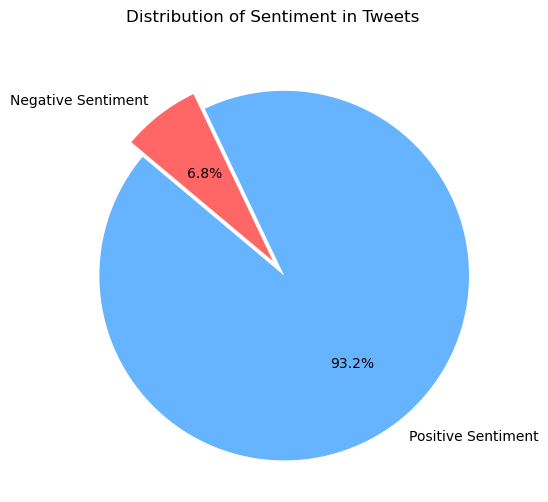

In [10]:
# Calculate percentages of positive and negative sentiment tweets
positive_percentage = 100 * (df['label'].value_counts().get(0, 0)) / len(df)
negative_percentage = 100 * (df['label'].value_counts().get(1, 0)) / len(df)

# Print the results with updated messages
print(f'Percentage of Positive Sentiment Tweets: {positive_percentage:.2f}%')
print(f'Percentage of Negative Sentiment Tweets: {negative_percentage:.2f}%')
print('\nThe dataset is significantly imbalanced.')

# Prepare data for the pie chart
labels = ['Positive Sentiment', 'Negative Sentiment']
sizes = [positive_percentage, negative_percentage]
colors = ['#66b3ff', '#ff6666']  # Optional: define custom colors for the chart
explode = (0.1, 0)  # Optional: "explode" the first slice for emphasis

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title('Distribution of Sentiment in Tweets')
plt.show()

# Part 2: Feature Extraction


1. **`import nltk`**:
   - This line imports the **Natural Language Toolkit (NLTK)**, a popular Python library used for working with human language data (text). It provides tools for various NLP tasks, such as tokenization, stemming, lemmatization, and handling stop words.
   
2. **`nltk.download('stopwords')`**:
   - This line downloads the **stopwords dataset** from NLTK's library. 
   - **Stopwords** are common words in a language that usually don't carry much meaning (like "is," "the," "and," etc.) and are often removed from text during preprocessing to focus on more meaningful words. 

3. **`stop_words = stopwords.words('english')`**:
   - This line creates a variable named `stop_words` that holds a list of **English stopwords**.
   - `stopwords.words('english')` retrieves the list of English stopwords from the NLTK stopwords dataset.
   - Having this list allows you to easily filter out these words from your text data later in the process, making your analysis more focused on the keywords and unique terms in the dataset.

In [11]:
# Library for handling stop words in English

import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leslie/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Hashtags Count

#### **One interesting feature which we can extract from a tweet is to calculate the number of hashtags in it. It helps in extracting extra information from our text data.**

In [12]:
def num_of_hash_tags(df):
    df['hashtags_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

### Word Count

#### **Usually, negative sentiments contain a lesser amount of words than the positive ones. So, this is a feature worth trying out**

In [13]:
def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))

### Character Count

#### **Similar logic as above can be applied here**

In [14]:
#calculates the total number of characters across all words in each tweet
def num_of_chars(df):
    df['char_count'] = df['tweet'].apply(lambda x: sum(list(map(len,x.split(' ')))))

### Number Count

#### **Just like we calculated the number of words and characters, we can also calculate the number of numerics which are present in the tweets. It might be a useful feature**

- If a tweet is "I have 2 apples and 5 bananas", the function will count 2 and 5 as numeric words, resulting in num_count = 2 for this tweet.

In [15]:
def num_of_num(df):
    df['num_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

### Stopwords Count

#### **Generally, while solving any NLP problem, the first thing we do is to remove the stopwords. A stop word is a commonly used word such as the, a, an, in which are filtered out before or after processing of natural language data (text).** 

In [16]:
def num_of_stop_words(df):
    df['stopwords_count'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

### Uppercase words

#### **Anger or rage is quite often expressed by writing in UPPERCASE words which makes this a necessary operation to identify those words.**

In [17]:
def num_of_upper(df):
    df['upper_case'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

### Feature Extraction Function

In [18]:
# Define a function to apply multiple feature extraction functions on a DataFrame
def feature_extract(df):
    num_of_hash_tags(df)
    num_of_num(df)
    num_of_chars(df)
    num_of_stop_words(df)
    num_of_upper(df)

# Part 3: Data Cleaning and Text Preprocessing

### Unlike stemming, which simply chops off word endings, lemmatization considers the context and morphological structure of the word to find the actual root.

- Lemmatization is the process of reducing words to their base or root form (called a lemma). For example, "running," "ran," and "runs" would all be lemmatized to "run."
- Word.lemmatize('running') would return "run".

In [19]:
# Lemmatization
# This creates an instance of the WordNetLemmatizer class and assigns it to the variable Word
Word = WordNetLemmatizer()

###  Removing hyperlinks and markup

- re.sub(pattern, replacement, result) finds all occurrences of pattern in result and replaces them with replacement.

In [20]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
#     result = re.sub('&quot;', '"', result) 
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result) 
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline 
    return result

### Removing Emojis

In [21]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x) 
# searches through x (the input text) for any characters matching the pattern (emojis) and 
# replaces them with '' (nothing). 

### Removing Punctuation and some symbols

####  **Removing punctuation as it doesn’t add any extra information while treating text data. Removing these symbols also helps reduce data size**

In [22]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

### Converting text to lower case

In [23]:
def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

### Removing Stopwords

#### **Generally, while solving any NLP problem, the first thing we do is to remove the stopwords. A stop word is a commonly used word such as the, a, an, in which are filtered out before or after processing of natural language data (text).** 

In [24]:
def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

### Removing the word user

#### **This has been done as the word user is just a placeholder for the actual user names and so, occurs many times without providing any useful information**

In [25]:
def remove_word_user(df):    
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

### Spell Correction

- TextBlob(x): Creates a `TextBlob` object from the tweet text x. TextBlob is a library in Python for processing textual data, including tasks like spell correction, sentiment analysis, and more.
- .correct(): The correct() method in TextBlob attempts to correct any misspelled words in the text. It does this by comparing words to common spelling patterns and replacing misspelled words with the most likely correct words.

In [26]:
def spell_correction(df):
    df['tweet'].apply(lambda x: str(TextBlob(x).correct()))

### Lemmatization

#### **Lemmatization is the process of converting a word to its base form. The difference between stemming and lemmatization is, lemmatization considers the context and converts the word to its meaningful base form, whereas stemming just removes the last few characters, often leading to incorrect meanings and spelling errors. Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices.**

In [27]:
def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

### Rare Words Removal: reduce noise and focus on more commonly occurring terms

In [28]:
# Identify and remove the five least frequently occurring words from each tweet in the tweet column of the DataFrame.

lst = pd.Series(' '.join(df['tweet']).split()).value_counts()[-5:]
lst = list(lst.index)
def rare_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in lst))

### Cleaning Function

In [29]:
def cleaning(df):
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(deEmojify)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
#     rare_words_removal(df)
#     spell_correction(df)
    lemmatize(df)

In [30]:
# Download the wordnet corpus
import nltk
nltk.download('wordnet')

# Calling the functions to extract features from my data and clean/preprocess it.
feature_extract(df)
cleaning(df)

[nltk_data] Downloading package wordnet to /Users/leslie/nltk_data...


# Part4: Visualization

(-0.5, 399.5, 199.5, -0.5)

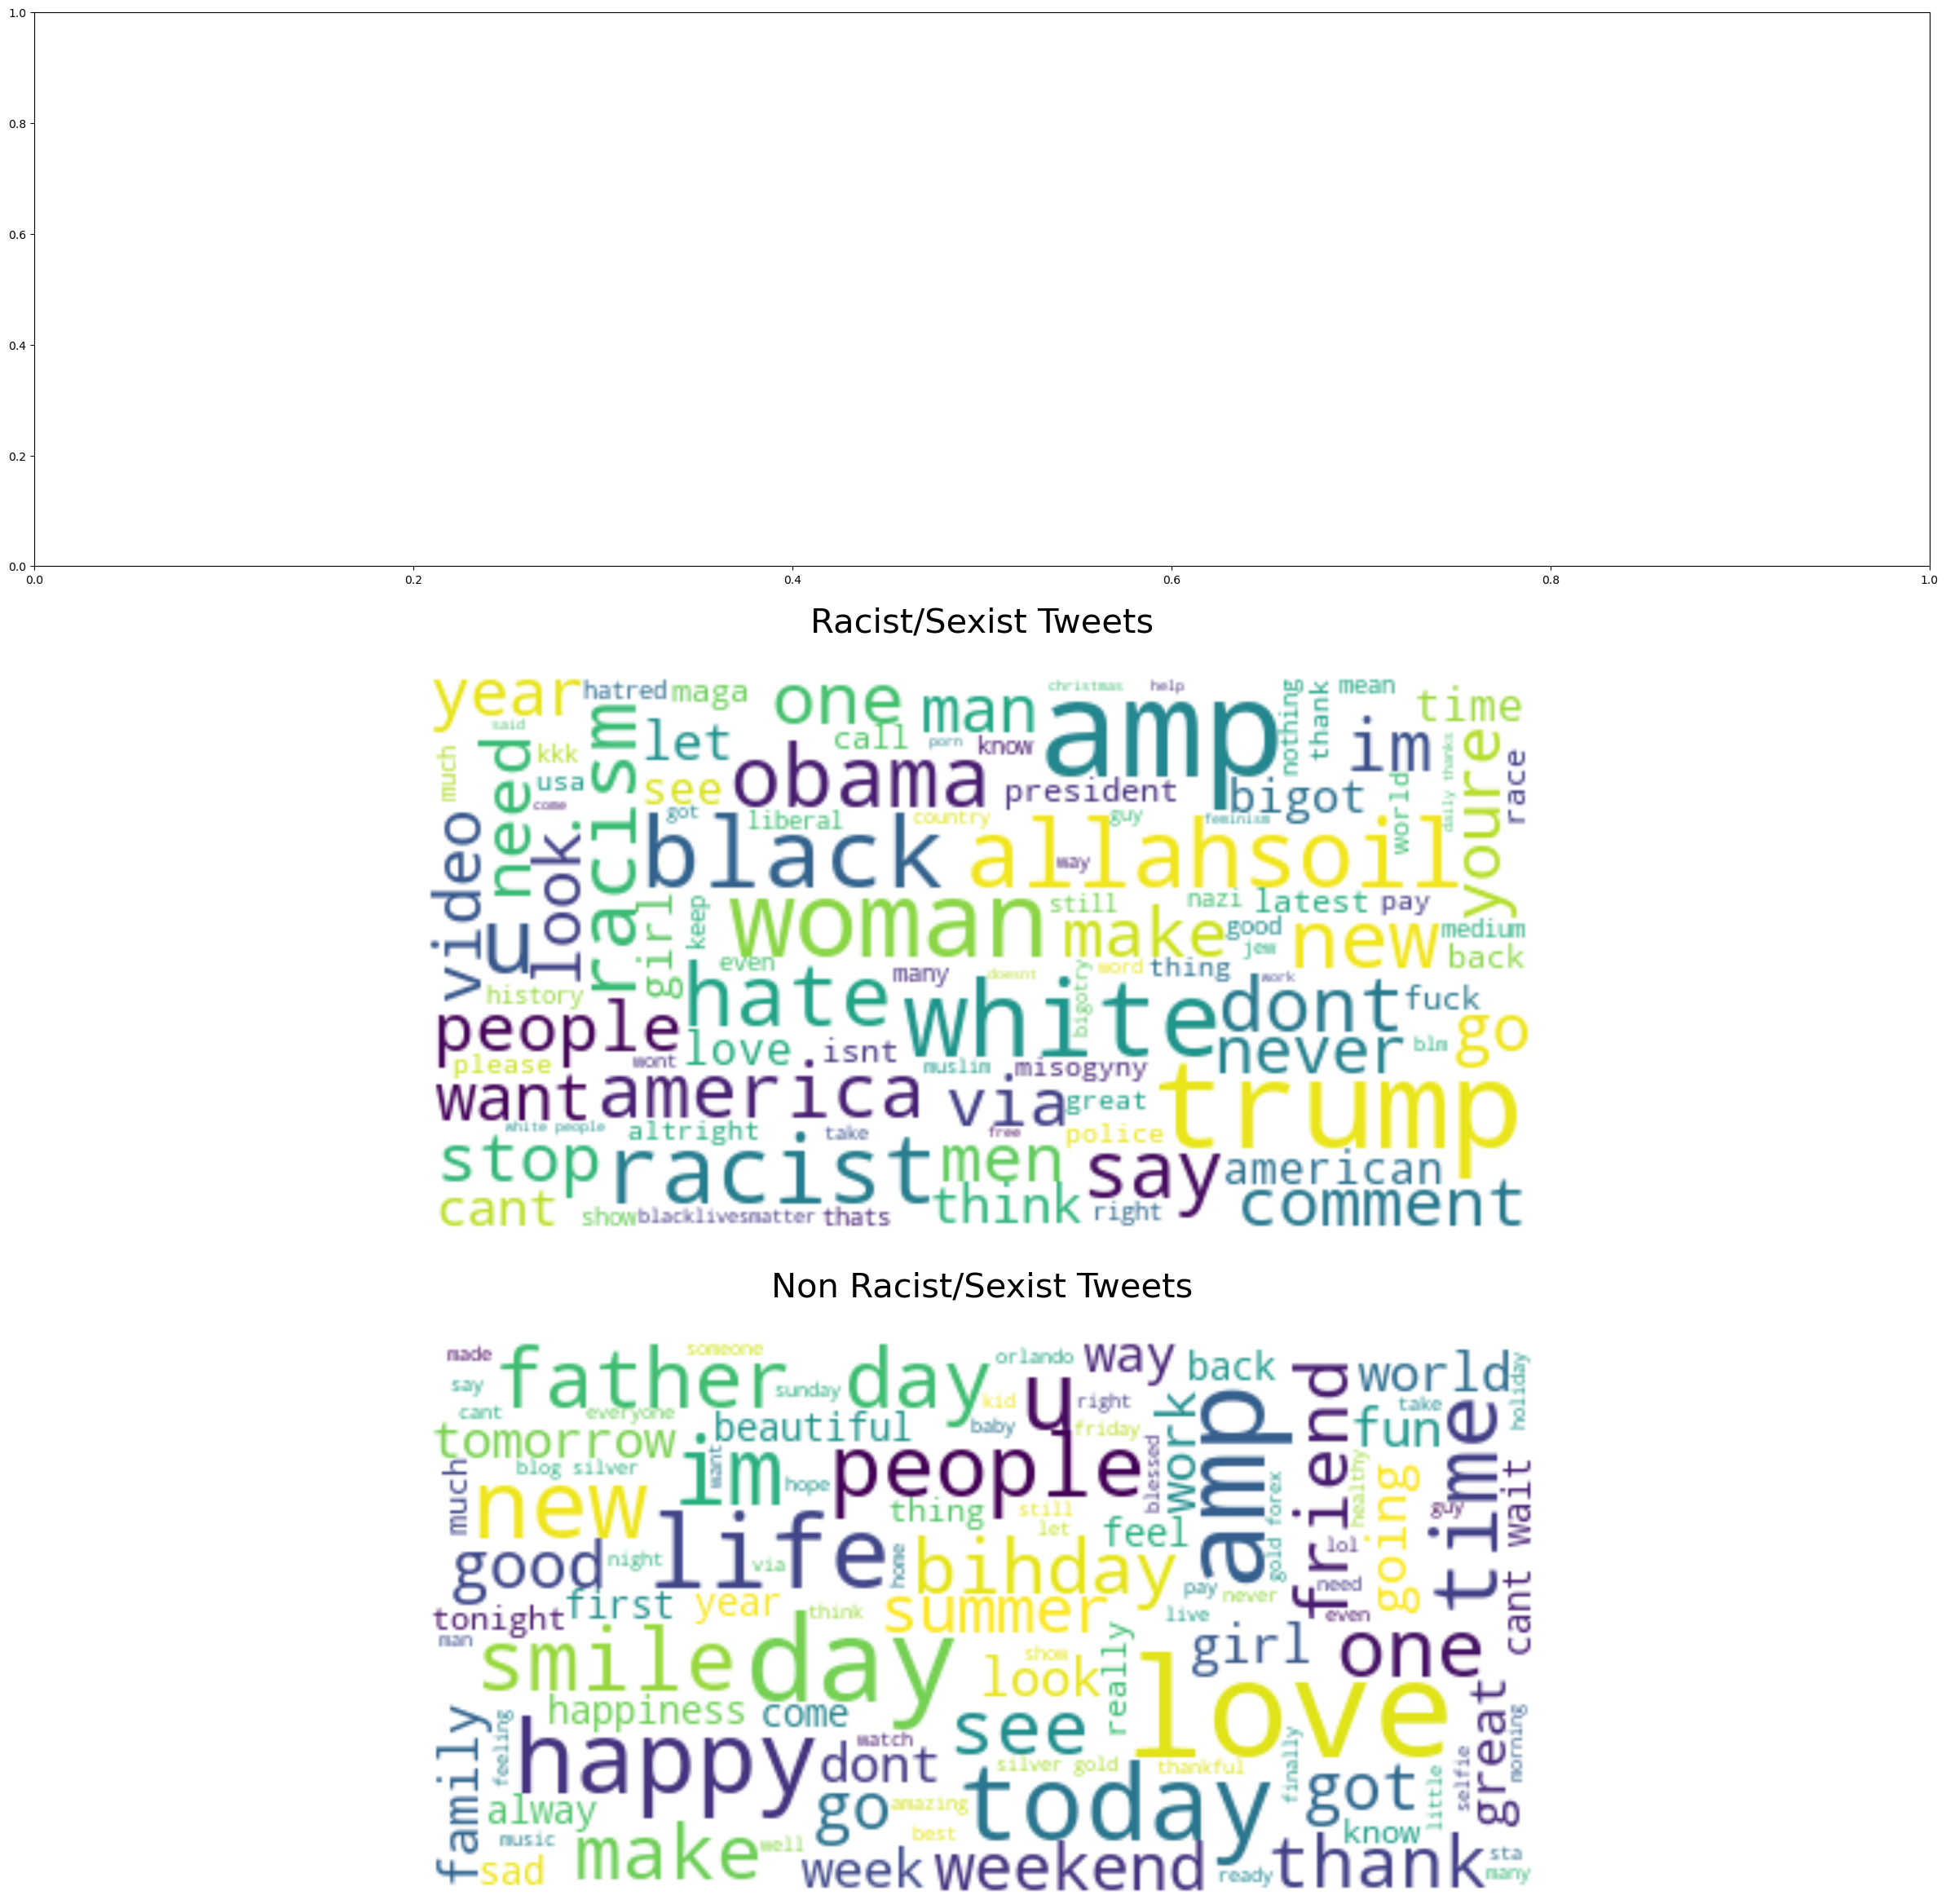

In [31]:
# Separate the Data into racist and non-racist comments
df_RS = df[df['label']==1]
df_NRS = df[df['label']==0]

# Combine Text from Each Group into Strings:
tweet_RS = " ".join(review for review in df_RS.tweet)
tweet_NRS = " ".join(review for review in df_NRS.tweet)

# Creates a figure with 3 rows and 1 column for displaying the three word clouds.
fig, ax = plt.subplots(3, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_RS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_RS)
wordcloud_NRS = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_NRS)

# Display the generated image:
ax[1].imshow(wordcloud_RS, interpolation='bilinear')
ax[1].set_title('\nRacist/Sexist Tweets\n',fontsize=30)
ax[1].axis('off')
print('\n')
ax[2].imshow(wordcloud_NRS, interpolation='bilinear')
ax[2].set_title('\nNon Racist/Sexist Tweets\n',fontsize=30)
ax[2].axis('off')


### To what extent do linguistic and structural features correlate with hate speech content on Twitter? 

Index(['label', 'tweet', 'hashtags_count', 'num_count', 'char_count',
       'stopwords_count', 'upper_case'],
      dtype='object')
Correlations with hate speech label:
hashtags_count          NaN
num_count               NaN
char_count         0.061581
stopwords_count    0.017702
upper_case              NaN
Name: label, dtype: float64


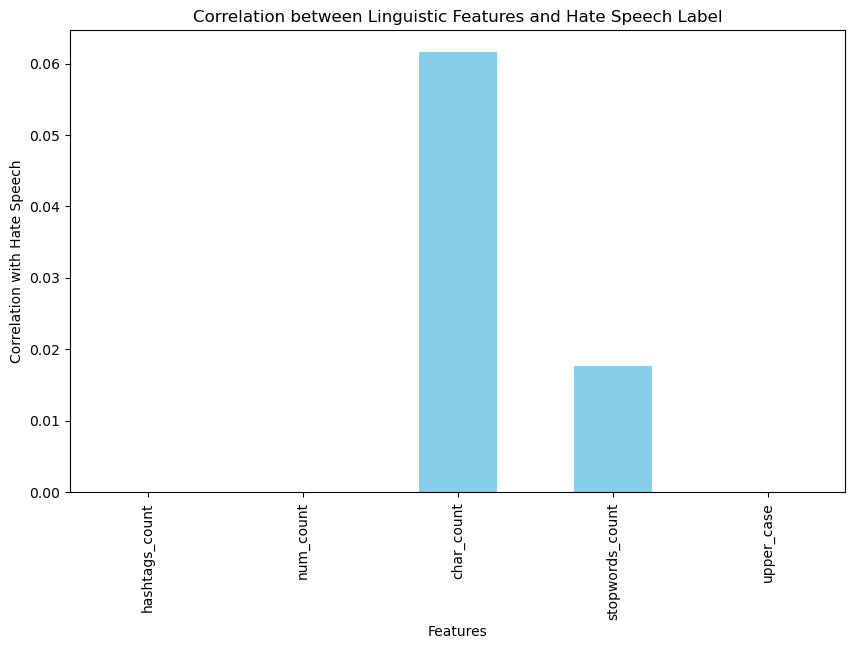

In [32]:
# Make sure to extract features
feature_extract(df)  # Run this if not already done

# Check if features are added to df
print(df.columns)

# Calculate correlations between available features and the hate speech label
correlations = df[['label', 'hashtags_count', 'num_count', 'char_count', 'stopwords_count', 'upper_case']].corr()['label'].drop('label')

# Display correlations
print("Correlations with hate speech label:")
print(correlations)

# Visualize correlations with a bar plot
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar', color='skyblue')
plt.title('Correlation between Linguistic Features and Hate Speech Label')
plt.xlabel('Features')
plt.ylabel('Correlation with Hate Speech')
plt.show()

## Topic Modeling

Topic 1:
happiness new smile make want love today bihday happy life


Topic 2:
cute time ready beautiful fun smile amp day summer love


Topic 3:
morning silver gold happy love blog fathersday dad father day


Topic 4:
white know woman say dog trump dont orlando amp people


Topic 5:
love going got sad need look week thankful im like




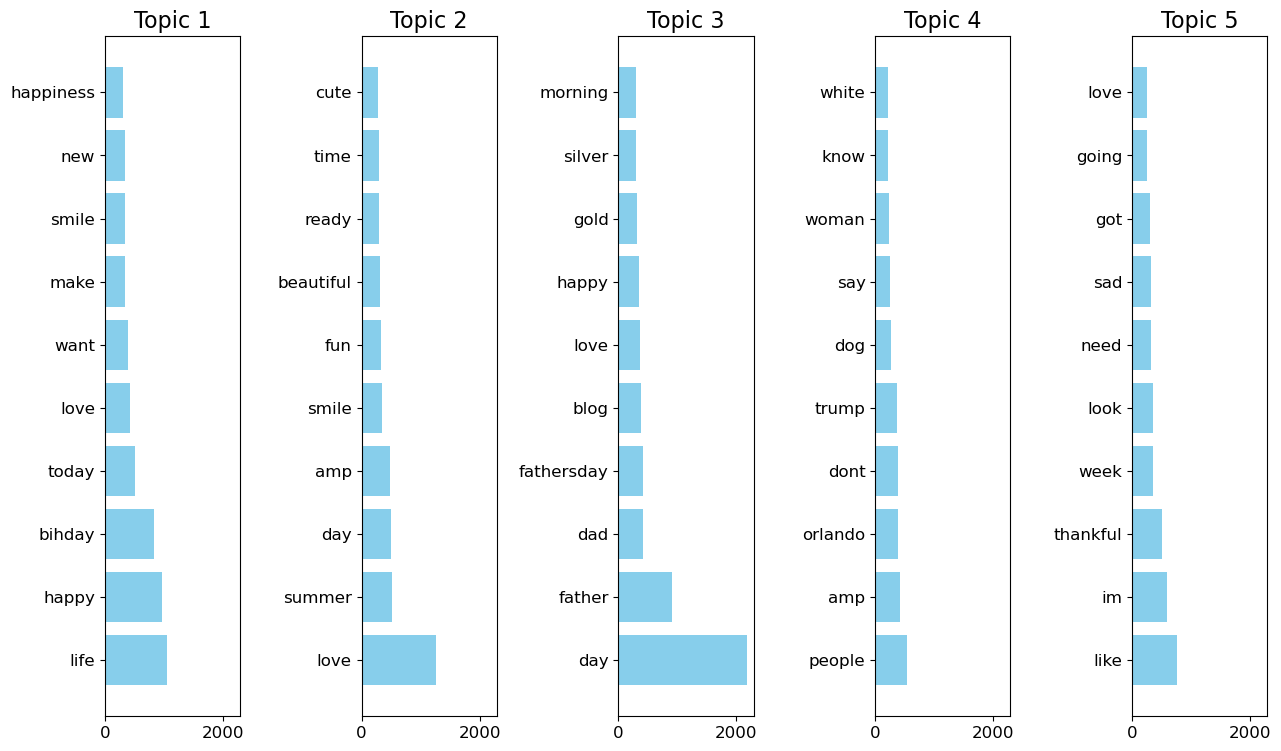

In [33]:
# Import required libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Sample data (replace 'df' with your actual DataFrame and 'tweet' with your text column)
# Ensure 'df' contains the cleaned/preprocessed tweets in 'tweet' column

# Step 1: Prepare the document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['tweet'])

# Step 2: Fit the LDA model
num_topics = 5  # You can adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(doc_term_matrix)

# Step 3: Display topics with top words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-no_top_words:]]))
        print("\n")

no_top_words = 10  # Number of top words to display per topic
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)


# Step 4 : Bar plot visualization of top words in each topic using matplotlib
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(1, model.n_components, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='skyblue')
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=16)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Plot the top words for each topic using matplotlib
plot_top_words(lda, feature_names, no_top_words)


In [34]:
# Looking at the dataset after various transformations
df.head(10)

,label,tweet,hashtags_count,num_count,char_count,stopwords_count,upper_case
0,0,father dysfunctional selfish drag kid dysfunct...,0,0,47,0,0
1,0,thanks lyft credit cant use cause dont offer w...,0,0,74,0,0
2,0,bihday majesty,0,0,13,0,0
3,0,model love u take u time ur,0,0,21,0,0
4,0,factsguide society motivation,0,0,27,0,0
5,0,huge fan fare big talking leave chaos pay disp...,0,0,58,0,0
6,0,camping tomorrow danny,0,0,20,0,0
7,0,next school year year exam cant think school e...,0,0,82,0,0
8,0,love land allin cavs champion cleveland clevel...,0,0,52,0,0
9,0,welcome im gr,0,0,11,0,0


In [35]:
# Separating data and labels

X = df.drop('label', axis = 'columns') #  input data to make predictions
y = df['label'] # target variable 

# Part 5: Modeling

In [36]:
# defining a function to evaluate my models based on certain metrics 
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_train,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_test,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

## Creating pipeline for tokenizing and modelling

- stop_words="english": Removes common English stop words (like "the", "and", etc.).
- max_features=3000: Limits the number of features to the 3000 most frequently occurring terms.
- ngram_range=(1,2): Extracts both unigrams (single words) and bigrams (two-word combinations) as features.

In [37]:
# Step 1: Initialize and fit the CountVectorizer using the original DataFrame containing 'tweet'
vector = CountVectorizer(stop_words="english", max_features=3000, ngram_range=(1, 2))

# Ensure you're fitting and transforming on the correct DataFrame, likely df instead of X
trans = vector.fit(df['tweet'])  # Fit on the original DataFrame that still has 'tweet'
x = trans.transform(df['tweet'])  # Get the term-document matrix

# Step 2: Get the feature names (actual words or phrases)
feature_names = vector.get_feature_names_out()

# Step 3: Remove the original 'tweet' text column from X
X = X.drop('tweet', axis='columns', errors='ignore')  # 'errors="ignore"' avoids errors if 'tweet' isn't present

# Step 4: Create a DataFrame from the dense matrix with feature names as columns
X_term_df = pd.DataFrame(x.todense(), columns=feature_names)

# Step 5: Concatenate with the original columns in X
X = pd.concat([X.reset_index(drop=True), X_term_df.reset_index(drop=True)], axis=1)

# Step 6: Fill any missing values with 0
X = X.fillna(0)

In [38]:
X

,hashtags_count,num_count,char_count,stopwords_count,upper_case,aap,able,absolute,absolutely,abt,...,youtuber,youve,yoy,yr,yr old,yum,yummy,yup,zelda,zen
0,0,0,47,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,74,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29525,0,0,37,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29526,0,0,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29527,0,0,79,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29528,0,0,39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Dealing with imbalanced data

# Define SMOTE and RandomUnderSampler with your desired sampling strategies
over = SMOTE(sampling_strategy=0.4) #  the minority class should have 40% of the samples compared to the majority class
under = RandomUnderSampler(sampling_strategy=0.5) 
# This helps bring down the count of the majority class, making it closer in size to the minority class.

# Create the pipeline with the steps for oversampling and undersampling
steps = [('over', over), ('under', under)]
pipeline = PL(steps=steps) 
# This pipeline first increases the minority class and then reduces the majority class, resulting in a more balanced dataset.

# Convert all column names in X to strings to avoid the TypeError
X.columns = X.columns.astype(str)

# Now apply fit_resample on the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X, y)

In [40]:
# Standard stratified train test split being done here but other validation strategies can be explored

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=40, test_size=0.20, stratify=y_resampled)

In [41]:
# Using simple untuned Random Forest Classifier Model

tfidf = TfidfTransformer() #convert raw word counts into TF-IDF (Term Frequency-Inverse Document Frequency) values.
model = RandomForestClassifier() #creates an instance of a Random Forest classifier.

- TF-IDF is a technique that helps us measure how important each word is, not just based on how many times it appears (frequency) but also considering how unique it is across all messages.
- Words that are common in a single message but not in others get higher scores.

In [42]:
# Creating pipeline, Term Frequency-Inverse Document Frequency (TFIDF)

pipeline2 = Pipeline([
    ('tfidf', tfidf),  # converting word counts to TF-IDF scores.
    ('model', model),  # Random Forest classifier to the transformed data
    ])
model_final = pipeline2.fit(X_train,y_train)
preds = model_final.predict(X_test)

# Part 6: Evaluation

Train Result:
Accuracy Score: 98.92%
_______________________________________________
ROC-AUC score: 
 0.9914816738601192

_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999193     0.969988  0.989172      0.984590      0.989458
recall         0.984553     0.998410  0.989172      0.991482      0.989172
f1-score       0.991819     0.983994  0.989172      0.987906      0.989211
support    17609.000000  8805.000000  0.989172  26414.000000  26414.000000
_______________________________________________
Confusion Matrix: 
 [[17337   272]
 [   14  8791]]


_______________________________________________

Test Result:
Accuracy Score: 94.75%
_______________________________________________
ROC-AUC score: 
 0.9396907110646854

_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.9

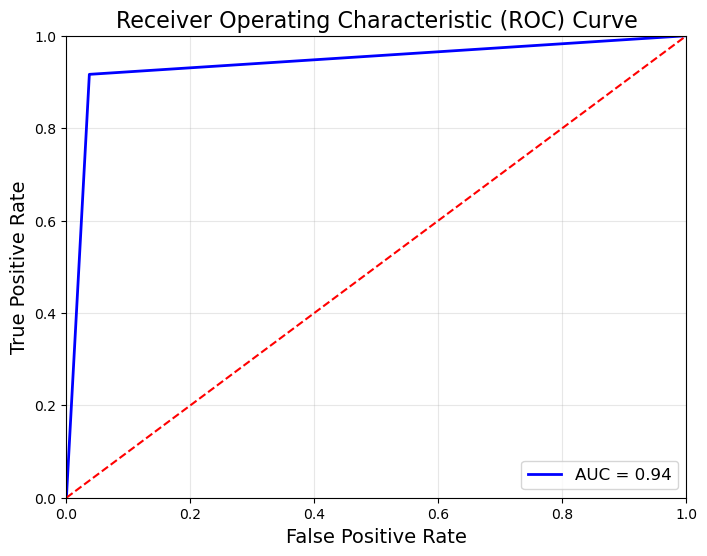

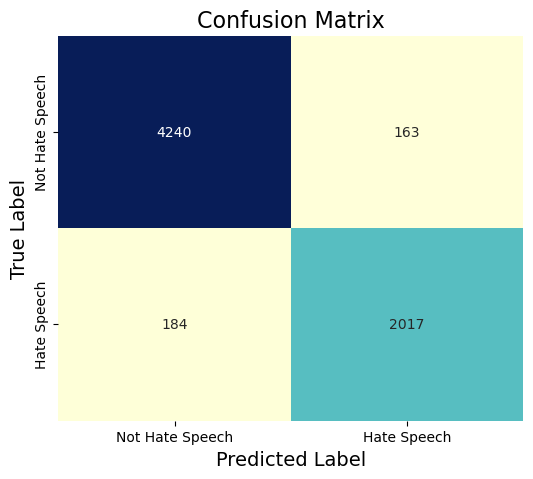

In [43]:
# Display train and test results
print_score(pipeline2, X_train, y_train, X_test, y_test, train=True)
print("\n_______________________________________________\n")
print_score(pipeline2, X_train, y_train, X_test, y_test, train=False)

# Plot ROC Curve
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1.5)  # Diagonal line for reference
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, pipeline2.predict(X_test))
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='YlGnBu', cbar=False,
            xticklabels=['Not Hate Speech', 'Hate Speech'],
            yticklabels=['Not Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

## Feature Importance

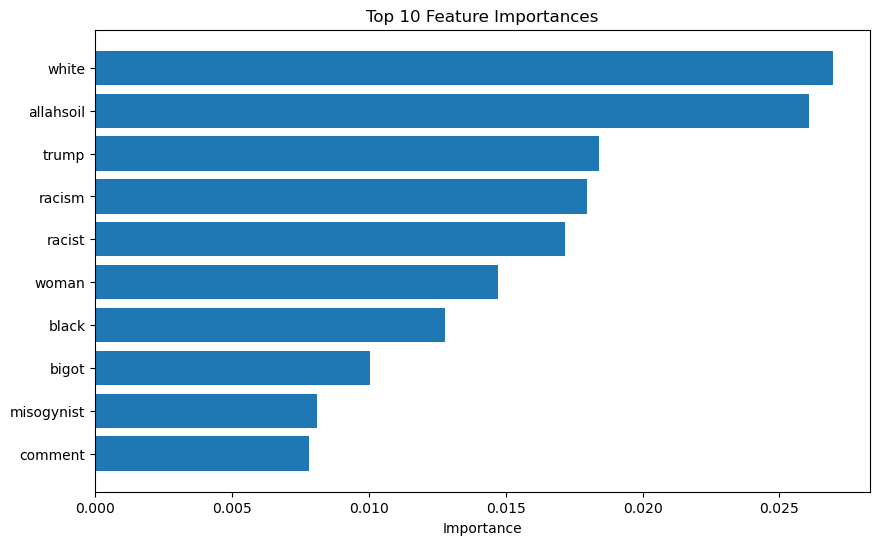

In [44]:
# Assuming `X` still has the 'tweet' column intact
# Split the original `X` and `y` before any transformations are applied

X_train, X_test, y_train, y_test = train_test_split(df[['tweet']], df['label'], random_state=40, test_size=0.20, stratify=df['label'])

# Redefine the full pipeline with CountVectorizer, TfidfTransformer, and RandomForestClassifier
full_pipeline = Pipeline([
    ('vector', CountVectorizer(stop_words="english", max_features=3000, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('model', RandomForestClassifier())
])

# Fit the pipeline on the text data
full_pipeline.fit(X_train['tweet'], y_train)

# Predictions (just as an example)
preds = full_pipeline.predict(X_test['tweet'])

# Extract feature importances from the RandomForest model
#  In a Random Forest model, 
# features that are more useful for splitting data across the trees receive higher importance scores.
feature_importances = full_pipeline.named_steps['model'].feature_importances_
feature_names = full_pipeline.named_steps['vector'].get_feature_names_out()

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and select the top 10 features
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # To show the most important feature at the top
plt.show()